In [1]:
import numpy as np
from glmnet import GLM
from glmnet.glm import GLMControl

from glmnet.glm_random import GibbsGLMFamilySpec
import statsmodels.api as sm

p, q = 100, 100 
n = 200 * q
rng = np.random.RandomState(0)

X = rng.standard_normal((n, p))
X[:,0] *= 3
Y = rng.choice([0,1], size=n)


In [2]:
G = GLM(family=sm.families.Binomial(), summarize=True)
G.fit(X, Y).summary_

,coef,std err,z,P>|z|
intercept,-0.003864,0.014211,-0.271893,0.785705
X0,-0.000561,0.004747,-0.118150,0.905949
X1,-0.016750,0.014169,-1.182159,0.237143
X2,0.004506,0.014139,0.318671,0.749976
X3,0.008908,0.014137,0.630098,0.528630
...,...,...,...,...
X95,0.017281,0.014181,1.218538,0.223019
X96,0.007783,0.014129,0.550895,0.581706
X97,-0.015174,0.014186,-1.069646,0.284779
X98,0.012565,0.014242,0.882229,0.377653


In [3]:
import rpy2
%load_ext rpy2.ipython
%R -i X,Y

In [4]:
%%R
summary(glm(Y ~ X, family=binomial))


Call:
glm(formula = Y ~ X, family = binomial)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.864e-03  1.421e-02  -0.272 0.785705    
X1          -5.608e-04  4.747e-03  -0.118 0.905948    
X2          -1.675e-02  1.417e-02  -1.182 0.237141    
X3           4.506e-03  1.414e-02   0.319 0.749975    
X4           8.908e-03  1.414e-02   0.630 0.528629    
X5           5.154e-03  1.421e-02   0.363 0.716763    
X6          -2.465e-02  1.424e-02  -1.731 0.083519 .  
X7           1.471e-02  1.437e-02   1.024 0.306012    
X8          -9.208e-04  1.414e-02  -0.065 0.948076    
X9           2.567e-02  1.419e-02   1.809 0.070424 .  
X10          1.670e-02  1.430e-02   1.168 0.242827    
X11         -1.447e-02  1.429e-02  -1.013 0.311083    
X12         -1.136e-02  1.416e-02  -0.803 0.422251    
X13         -8.610e-03  1.411e-02  -0.610 0.541792    
X14          1.072e-02  1.412e-02   0.759 0.447568    
X15         -2.984e-03  1.427e-02  -0.209 0.834353    
X16

In [5]:
control = GLMControl(mxitnr=2000)

fam = GibbsGLMFamilySpec(base=G._family.base)
GR = GLM(family=fam, control=control)
GR.fit(X, Y)

GLM(family=GibbsGLMFamilySpec(base=<statsmodels.genmod.families.family.Binomial object at 0x1033173a0>), fit_intercept=True, control=GLMControl(mxitnr=2000, epsnr=1e-06, big=9.9e+35, logging=False), summarize=False)

0.005253003033917459


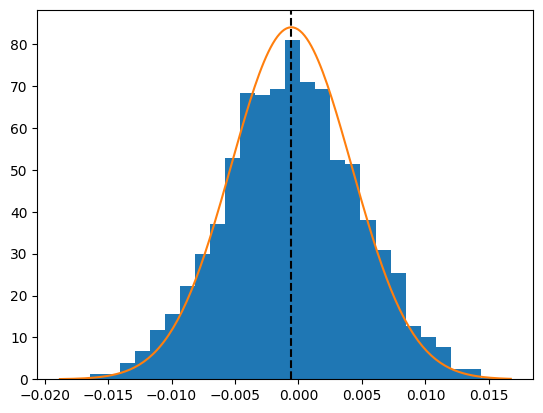

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
print(np.std(GR._history[:,1]))
ax.hist(GR._history[:,1], bins=30, density=True)
ax.axvline(G.summary_.loc['X0','coef'], ls='--', color='k')
from scipy.stats import norm as normal_dbn
xval = np.linspace(GR._history[:,1].min(), GR._history[:,1].max(), 200)
ax.plot(xval, normal_dbn.pdf(xval, loc=G.summary_.loc['X0','coef'], scale=G.summary_.loc['X0','std err']))

In [7]:
from glmnet.glmm import GLMM
from glmnet.base import Design
Z = rng.standard_normal((n, q))
nu = rng.standard_normal(q) / np.sqrt(q)
Z_nu = Z @ nu
prob = np.exp(Z_nu) / (1 + np.exp(Z_nu))
Y = rng.binomial(1, prob)
H, S = GLMM(GR._family,
      Design(X),
     Design(Z),
     Y,
     np.ones(n),
     GR.control,
     np.identity(q))

0.004540083236893886


0.9801980198019802

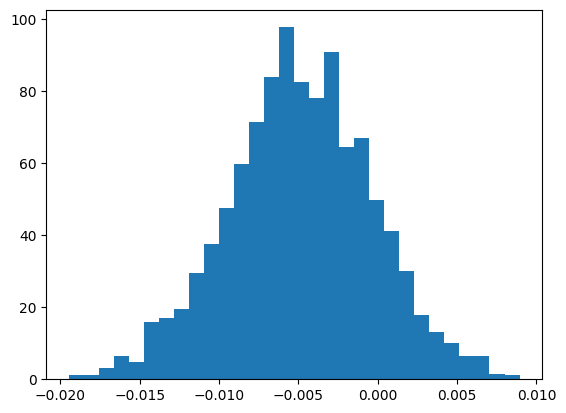

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
print(np.std(H[:,1]))
ax.hist(H[:,1], bins=30, density=True)
H_mean = np.mean(H, 0)
H_std = np.std(H, 0)
U = H_mean + 2 * H_std
L = H_mean - 2 * H_std
np.mean((L < 0) * (U > 0))

0.01297671935102202


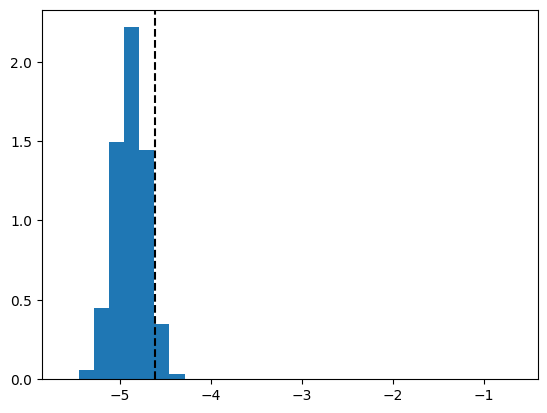

In [9]:
fig, ax = plt.subplots()
print(np.std(S))
ax.hist(np.log(S), bins=30, density=True)
ax.axvline(np.log(1/q), ls='--', c='k')